In [1]:
import torch
import torch.nn as nn

# My code starts here

In [25]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1):
        super(ResidualBlock,self).__init__()
        #convolution layer
        self.conv = [nn.Conv2d(in_channels, out_channels, kernel_size, padding=1, stride=stride),
                     nn.Conv2d(out_channels, out_channels, kernel_size, padding=1)]
        #batch norm layer
        self.bn = nn.BatchNorm2d(num_features=out_channels)
        
        self.relu = nn.ReLU(inplace=True)
        
        #transit the input x's shape to match the output f_x's shape
        self.trans = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride)
        
        #if input shape = output shape, no need to transut
        self.isChanged = not in_channels == out_channels
        
    def forward(self, x):
        f_x = self.conv[0](x)
        f_x = self.bn(f_x)
        f_x = self.relu(f_x)
        f_x = self.conv[1](f_x)
        f_x = self.bn(f_x)
        
        #residual path
        if(self.isChanged):
            x = self.trans(x)
        #residual add
        x = f_x + x
        
        return x
            

In [31]:
class ResNet(nn.Module):
    def __init__(self, output_classes):
        super(ResNet,self).__init__()
        #number of Blocks
        self.numBlocks = [2,2,2,2]
        #convolution layer
        self.conv = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, padding=3, stride=2)
        
        #residual blocks
        self.rblocks = [ResidualBlock(64,64),
                        ResidualBlock(64,128,stride=2),
                        ResidualBlock(128,128),
                        ResidualBlock(128,256,stride=2),
                        ResidualBlock(256,256),
                        ResidualBlock(256,512,stride=2),
                        ResidualBlock(512,512)]
        
        self.maxpool = nn.MaxPool2d(kernel_size=3, padding=1, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.linear = nn.Linear(512, output_classes)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.conv(x)
        x = self.maxpool(x)
        
        #block 1
        for i in range(2):
            x = self.rblocks[0](x)
        
        #block 2 ~ 4
        for i in range(1,7):
            x = self.rblocks[i](x)
        
        x = self.avgpool(x)
        #reshape
        x = x.view(-1,512)
        x = self.linear(x)
        x = self.softmax(x)
        
        return x

In [3]:
from torchsummary import summary

In [33]:
res = ResNet(output_classes=10)

In [34]:
summary(res, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,472
         MaxPool2d-2           [-1, 64, 56, 56]               0
 AdaptiveAvgPool2d-3            [-1, 512, 1, 1]               0
            Linear-4                   [-1, 10]           5,130
           Softmax-5                   [-1, 10]               0
Total params: 14,602
Trainable params: 14,602
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 7.66
Params size (MB): 0.06
Estimated Total Size (MB): 8.29
----------------------------------------------------------------


In [35]:
import torchvision
import torchvision.transforms as transforms

In [36]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100.0%

Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


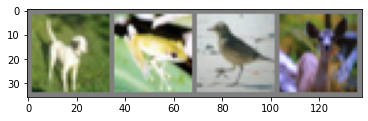

  dog  frog  bird  deer


In [38]:
 import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [40]:
import torch.optim as optim

resnet = ResNet(output_classes=10)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.parameters(), lr=0.001, momentum=0.9)

In [41]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        #print(i, end = " ")

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = resnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.214
[1,  4000] loss: 2.165
[1,  6000] loss: 2.147
[1,  8000] loss: 2.136
[1, 10000] loss: 2.133
[1, 12000] loss: 2.126
[2,  2000] loss: 2.118
[2,  4000] loss: 2.114
[2,  6000] loss: 2.112
[2,  8000] loss: 2.101
[2, 10000] loss: 2.097
[2, 12000] loss: 2.099
Finished Training


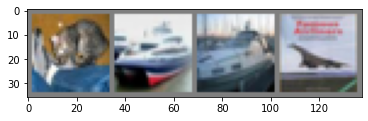

In [42]:
it = iter(testloader)
img, label = it.next()
imshow(torchvision.utils.make_grid(img))

In [43]:
out = resnet(img)

In [45]:
out[1]

tensor([4.3087e-05, 1.8973e-05, 5.7714e-10, 1.4252e-08, 1.9637e-09, 6.2595e-09,
        7.5561e-08, 3.1380e-12, 9.9294e-01, 7.0022e-03],
       grad_fn=<SelectBackward>)